In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from utils import *
import re


import seaborn as sns
import scipy.stats as stats


In [211]:
PARENT = "../TelevisionNews/"

cnn, fox, msnbc = get_data(PARENT)

cnn.set_index('DateTime', inplace=True)
cnn=cnn['Snippet']
cnn_month = cnn.groupby(pd.Grouper(freq="M")).count()
cnn_day = cnn.groupby(pd.Grouper(freq="D")).count()
cnn_yr = cnn.groupby(pd.Grouper(freq="Y")).count()

fox.set_index('DateTime', inplace=True)
fox=fox['Snippet']
fox_month = fox.groupby(pd.Grouper(freq="M")).count()
fox_day = fox.groupby(pd.Grouper(freq="D")).count()
fox_yr = fox.groupby(pd.Grouper(freq="Y")).count()

msnbc.set_index('DateTime', inplace=True)
msnbc=msnbc['Snippet']
msnbc_month = msnbc.groupby(pd.Grouper(freq="M")).count()
msnbc_day = msnbc.groupby(pd.Grouper(freq="D")).count()
msnbc_yr = msnbc.groupby(pd.Grouper(freq="Y")).count()

In [4]:
print(cnn_month)
print(cnn_day)
print(cnn_yr)

DateTime
2009-07-31    170
2009-08-31     65
2009-09-30     19
2009-10-31      0
2009-11-30    134
             ... 
2019-09-30    701
2019-10-31    216
2019-11-30    328
2019-12-31    374
2020-01-31    260
Freq: M, Name: Snippet, Length: 127, dtype: int64
DateTime
2009-07-03     4
2009-07-04     1
2009-07-05     5
2009-07-06     3
2009-07-07     0
              ..
2020-01-17     4
2020-01-18    30
2020-01-19    24
2020-01-20    21
2020-01-21    15
Freq: D, Name: Snippet, Length: 3855, dtype: int64
DateTime
2009-12-31    1894
2010-12-31     752
2011-12-31     609
2012-12-31     745
2013-12-31    1150
2014-12-31    1190
2015-12-31    1971
2016-12-31    2089
2017-12-31    2870
2018-12-31    1340
2019-12-31    4434
2020-12-31     260
Freq: A-DEC, Name: Snippet, dtype: int64


In [217]:
# checked out the length for the months after the IPCC report's release in Aug 2018
# note that this starts  in July
# will use this below to try to calculate correlation with disaster data
cnn_month[108:]

DateTime
2018-07-31     63
2018-08-31     55
2018-09-30     59
2018-10-31    142
2018-11-30    554
2018-12-31    196
2019-01-31    145
2019-02-28    347
2019-03-31    290
2019-04-30    205
2019-05-31    301
2019-06-30    585
2019-07-31    330
2019-08-31    612
2019-09-30    701
2019-10-31    216
2019-11-30    328
2019-12-31    374
2020-01-31    260
Freq: M, Name: Snippet, dtype: int64

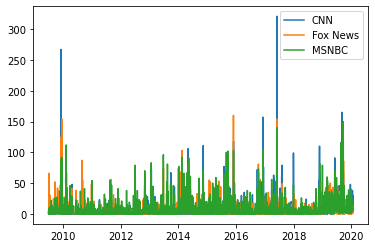

In [5]:
plt.plot(cnn_day, label='CNN')
plt.plot(fox_day, label='Fox News')
plt.plot(msnbc_day, label = 'MSNBC')
plt.legend()

#plt.xlim(0,21)
plt.show()

#cnn.set_index('DateTime', inplace=True)
#temp = temp.groupby(pd.Grouper(freq="M")).count()

#need to plot-align by date???

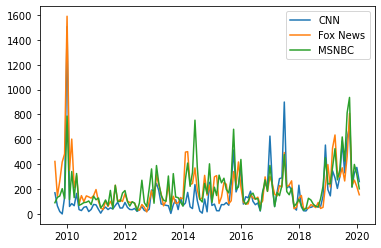

In [6]:
plt.plot(cnn_month, label='CNN')
plt.plot(fox_month, label='Fox News')
plt.plot(msnbc_month, label = 'MSNBC')
plt.legend()

#plt.xlim(0,21)
plt.show()



In [233]:
#priorities:

#DONE
#correlation between CNN, foxnews, msnbc (pearson)
#also correlation with disaster dataset
#see if correlation with disaster dataset is higher after IPCC report

#---#TODO
#normalize by total number of snippets -> then look at correlation --> I don't think we need to do this (disha)

#Dynamic Time Warping
#https://blog.statsbot.co/time-series-anomaly-detection-algorithms-1cef5519aef2
#see if there is annual or election cycle seasonality
#STL(seasonal trend loss) decomposition
#anomaly detection - STL is one subset of this


In [248]:
# do dynamic time warping with the daily network data, rather than  the monthly average
# DTW lets us do a one-to-many match across  unequal length time series which use different timestamps
# https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd
# also https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

# DTW with a window constraint
# here, s is one set of  time series data. t is another

def dtw(s, t, window):
    n, m = len(s), len(t)
    w = np.max([window, abs(n-m)])
    dtw_matrix = np.zeros((n+1, m+1))
    
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            dtw_matrix[i, j] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [249]:
cnn_fox_matrix = dtw(cnn_day, fox_day, 3)

In [250]:
# gotta figure out how  to interpret what this is telling me
# but here is the DTW matrix
cnn_fox_matrix

array([[0.0000e+00,        inf,        inf, ...,        inf,        inf,
               inf],
       [       inf, 3.0000e+00, 1.0000e+01, ...,        inf,        inf,
               inf],
       [       inf, 3.0000e+00, 1.3000e+01, ...,        inf,        inf,
               inf],
       ...,
       [       inf,        inf,        inf, ..., 1.7529e+04, 1.7521e+04,
        1.7517e+04],
       [       inf,        inf,        inf, ..., 1.7535e+04, 1.7534e+04,
        1.7526e+04],
       [       inf,        inf,        inf, ..., 1.7536e+04, 1.7541e+04,
        1.7529e+04]])

In [262]:
# # okay there is apparently a package, let's use that

# from dtw import dtw
# from fastdtw import fastdtw

# d1 = cnn_day.interpolate().values
# d2 = fox_day.interpolate().values

In [261]:
# distance, path = fastdtw(d1, d2, dist='euclidean')

# # plt.imshow(cnn_fox_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
# # plt.plot(path[0], path[1], 'w')
# # plt.xlabel('Subject1')
# # plt.ylabel('Subject2')
# # plt.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
# # plt.show()

In [130]:
# convert to ndarray
cnn_array = cnn_month.to_numpy()
fox_array = fox_month.to_numpy()
msnbc_array = msnbc_month.to_numpy()

print("cnn size",np.size(cnn_array))
print("fox size",np.size(fox_array))
print("msnbc size",np.size(msnbc_array))

cnn size 127
fox size 127
msnbc size 127


In [131]:
# make a dataframe containing all the counts per month
feature_list = ['cnn', 'fox', 'msnbc']

In [132]:
d_all = pd.DataFrame(0, index=np.arange(len(msnbc_array)), columns=feature_list)

In [133]:
d_all

,cnn,fox,msnbc
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
122,0,0,0
123,0,0,0
124,0,0,0
125,0,0,0


In [134]:
cnn_len = len(cnn_array)
d_all.iloc[:cnn_len,0] = cnn_array

fox_len = len(fox_array)
d_all.iloc[:fox_len,1] = fox_array

msnbc_len = len(msnbc_array)
d_all.iloc[:msnbc_len,2] = msnbc_array

In [135]:
d_all

,cnn,fox,msnbc
0,170,422,90
1,65,143,133
2,19,264,144
3,0,418,203
4,134,483,123
...,...,...,...
122,701,810,937
123,216,230,217
124,328,272,398
125,374,219,317


In [161]:
# calculate Pearson correlation between each of the time series overall
# should expect self correlation of 1
overall_pearson_r = d_all.corr(method='pearson')

In [137]:
overall_pearson_r

,cnn,fox,msnbc
cnn,1.000000,0.759091,0.760837
fox,0.759091,1.000000,0.712548
msnbc,0.760837,0.712548,1.000000


In [145]:
print(f"Pandas computed Pearson r:\n {overall_pearson_r}")

Pandas computed Pearson r:
             cnn       fox     msnbc
cnn    1.000000  0.759091  0.760837
fox    0.759091  1.000000  0.712548
msnbc  0.760837  0.712548  1.000000


In [151]:
r1, p1 = stats.pearsonr(d_all.dropna()['cnn'], d_all.dropna()['fox'])
print(f"Scipy computed Pearson r for CNN and Fox: {r1} and p-value: {p1}")

Scipy computed Pearson r for CNN and Fox: 0.7590908857002362 and p-value: 4.636463415740109e-25


In [152]:
r1, p1 = stats.pearsonr(d_all.dropna()['cnn'], d_all.dropna()['msnbc'])
print(f"Scipy computed Pearson r for CNN and MSNBC: {r1} and p-value: {p1}")

Scipy computed Pearson r for CNN and MSNBC: 0.7608373609427609 and p-value: 3.123613285765149e-25


In [153]:
r1, p1 = stats.pearsonr(d_all.dropna()['fox'], d_all.dropna()['msnbc'])
print(f"Scipy computed Pearson r for MSNBC and Fox: {r1} and p-value: {p1}")

Scipy computed Pearson r for MSNBC and Fox: 0.7125476300512148 and p-value: 5.748856661175154e-21


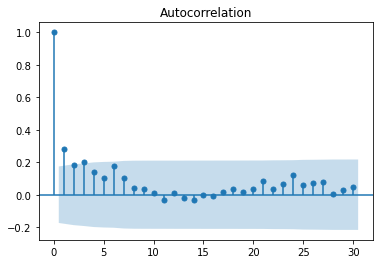

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(cnn_month, lags=30)
plt.show()

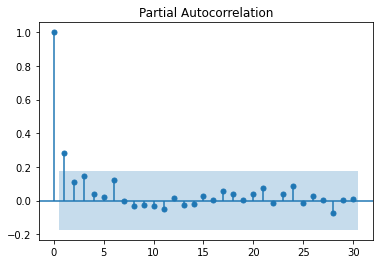

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(cnn_month, lags=30)
plt.show()

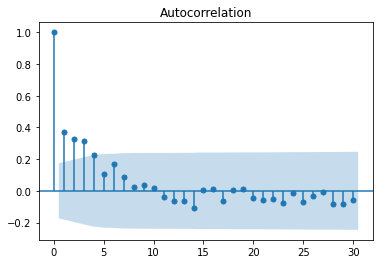

In [10]:
plot_acf(msnbc_month, lags=30)
plt.show()

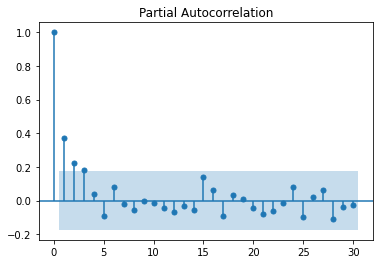

In [11]:
plot_pacf(msnbc_month, lags=30)
plt.show()

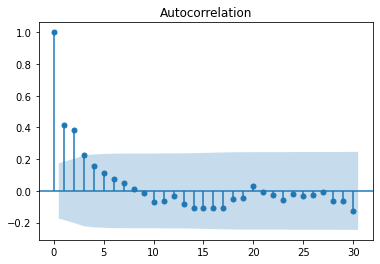

In [12]:
plot_acf(fox_month, lags=30)
plt.show()

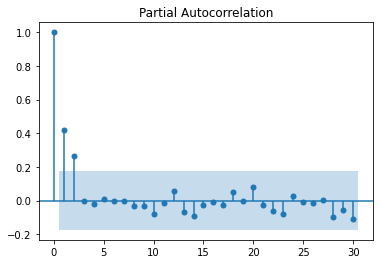

In [13]:
plot_pacf(fox_month, lags=30)
plt.show()

In [14]:
#Questions

#need to plot-align by date???
####need to fill in 2009-10 (missing for CNN)
#print(cnn)
cnn2, fox2, msnbc2 = get_data(PARENT)

#groupby year
cnn_yr2=cnn2.groupby(cnn2.DateTime.dt.to_period("Y")).count()
fox_yr2=fox2.groupby(fox2.DateTime.dt.to_period("Y")).count()
msnbc_yr2=msnbc2.groupby(msnbc2.DateTime.dt.to_period("Y")).count()


In [158]:
# #groupby month
# cnn_month2=cnn2.groupby(cnn2.DateTime.dt.to_period("M")).count()
# fox_month2=fox2.groupby(fox2.DateTime.dt.to_period("M")).count()
# msnbc_month2=msnbc2.groupby(msnbc2.DateTime.dt.to_period("M")).count()

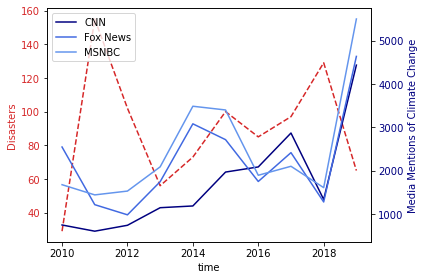

In [17]:
disasters=pd.read_csv('../state-freq-data.csv', header=1)
#print(disasters['year'])
dist_us=disasters.groupby(disasters['year']).sum()
dist_us['Total']=dist_us.drought+dist_us.freeze+dist_us['severe storm']+dist_us['tropical cyclone']+dist_us.wildfire+dist_us['winter storm']
#print(dist_us)

def plot_disasters(disttype):
    t=list(range(2010,2020))

    fig, ax1=plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('time')
    ax1.set_ylabel('Disasters', color=color)
    y=dist_us[disttype].values[(2010-1980):(2019-1980+1)]
    ax1.plot(t, y, "--",color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'navy'
    ax2.set_ylabel('Media Mentions of Climate Change', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, cnn_yr2['DateTime'].values[1:-1], color=color, label='CNN')
    ax2.plot(t, fox_yr2['DateTime'].values[1:-1], color="royalblue", label='Fox News')
    ax2.plot(t, msnbc_yr2['DateTime'].values[1:-1], color="cornflowerblue", label='MSNBC')

    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.legend()
    plt.show()

#plt.plot(dist_us.Total[2010:2019], label="Billion dollar disasters in the US")
#plt.plot(cnn_yr['DateTime'].values[1:-1], label="Frequency of Climate Change Mentions")
#plt.show()

plot_disasters('Total')

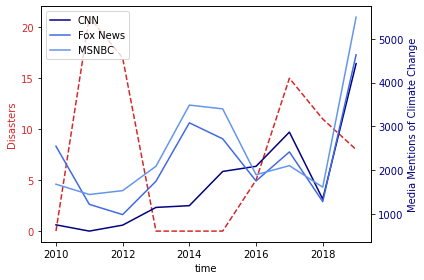

In [18]:
plot_disasters('tropical cyclone')

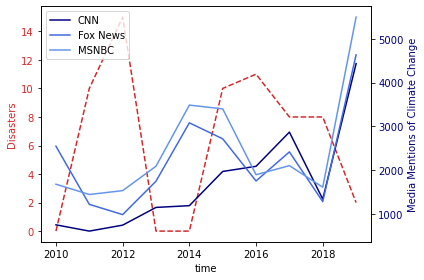

In [19]:
plot_disasters('wildfire')

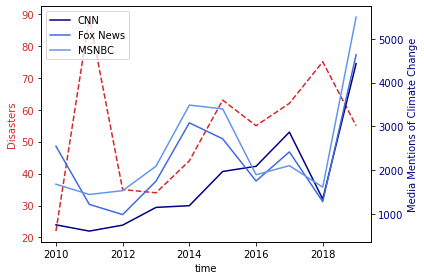

In [20]:
plot_disasters('severe storm')

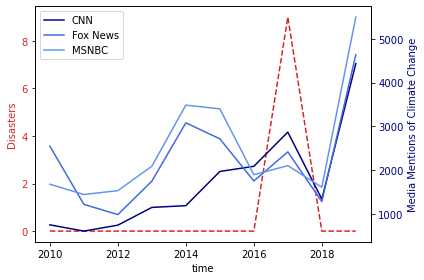

In [21]:
plot_disasters('freeze')

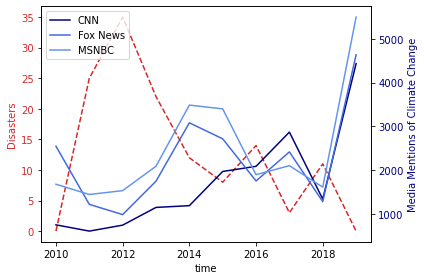

In [22]:
plot_disasters('drought')

## Kaggle Disaster Dataset

In [23]:
climate_disasters=['Fire','Severe Storm(s)','Hurricane','Flood','Coastal Storm','Typhoon']
print('Flood' in climate_disasters)

True


In [165]:
dist2=pd.read_csv('../us_disaster_declarations.csv')

dist2['DateTime']=pd.to_datetime(dist2.declaration_date.str.split("T", expand=True)[0], errors='ignore')
start_date="2009-08-01"
end_date="2019-12-31"

dist2=get_data_between_dates(dist2, start_date, end_date)

dist2.set_index('DateTime', inplace=True)

climate_disasters=['Fire','Severe Storm(s)','Hurricane','Flood','Coastal Storm','Typhoon']
dist2=dist2[dist2['incident_type'].isin(climate_disasters)]

In [168]:
#only look at 2010-2019
#only look at ih_program_declared=1, ia_program_declared=1
#only look at designated_area=statewide

#dist2=dist2[dist2.ih_program_declared==1]
#dist2=dist2[dist2.ia_program_declared==1]
#dist2=dist2[dist2.designated_area=='Statewide']

#groupby months
#group incident type, total
#print(cnn)
#print(dist2)

dist2_m = dist2.groupby(pd.Grouper(freq="M")).count()
dist2_day = dist2.groupby(pd.Grouper(freq="D")).count()

In [204]:
dist_array = dist2_m['disaster_number'].to_numpy()
dist_array.size

125

In [218]:
# set up for disaster and climate instance correlation, monthly avg

In [190]:
cnn_array

array([ 170,   65,   19,    0,  134, 1506,   60,   83,   66,  165,   35,
         27,   53,   59,   19,   36,   76,   73,   36,    6,   39,   55,
         35,   49,   40,   68,   94,   47,   48,   92,   53,   36,   34,
         44,   21,   33,   59,   28,   22,   38,  192,  185,  245,  190,
         80,   75,   69,   66,    4,   74,  114,   35,  132,   66,   88,
        173,   57,   43,  236,  105,   23,    6,  120,   17,  254,   68,
         79,   26,   25,   75,   74,   91,   70,  240,  514,  177,  232,
        368,   79,  138,  130,  183,  101,   74,   88,   23,  180,  238,
        229,  626,  227,   59,  174,  284,  290,  900,  208,  224,  191,
         51,   31,  231,   57,   25,   24,   51,   53,   61,   63,   55,
         59,  142,  554,  196,  145,  347,  290,  205,  301,  585,  330,
        612,  701,  216,  328,  374,  260])

In [225]:
df_dist = pd.DataFrame(0, index=np.arange(len(cnn_array)), columns=['disasters total', 'cnn', 'fox', 'msnbc'])

In [226]:
df_dist.iloc[:len(dist_array), 0] = dist_array
df_dist.iloc[:len(cnn_array), 1] = cnn_array
df_dist.iloc[:len(fox_array), 2] = fox_array
df_dist.iloc[:len(msnbc_array), 3] = msnbc_array

In [227]:
df_dist

,disasters total,cnn,fox,msnbc
0,24,170,422,90
1,38,65,143,133
2,7,19,264,144
3,0,0,418,203
4,93,134,483,123
...,...,...,...,...
122,75,701,810,937
123,29,216,230,217
124,47,328,272,398
125,0,374,219,317


In [228]:
# calculate pearson correlation between networks and disasters
# should expect self correlation of 1
disaster_pearson_r = df_dist.corr(method='pearson')

In [229]:
disaster_pearson_r

,disasters total,cnn,fox,msnbc
disasters total,1.000000,-0.024330,-0.045675,-0.011704
cnn,-0.024330,1.000000,0.759091,0.760837
fox,-0.045675,0.759091,1.000000,0.712548
msnbc,-0.011704,0.760837,0.712548,1.000000


In [199]:
# find pearson correlation between all the networks' climate mentions (summed) and summed disaster types
summed_instances = df_dist['cnn'] + df_dist['fox'] + df_dist['msnbc']

In [207]:
# make a dataframe with the summed climate mentions
df_sum = pd.DataFrame(0, index=np.arange(len(summed_instances)), columns=['disasters', 'summed mentions'])

# # fill it with fun stuff, like the summed instances (column 2) and the disaster incidence
df_sum.iloc[:len(dist_array), 0] = dist_array
df_sum.iloc[:len(summed_instances), 1] = summed_instances
df_sum

,disasters,summed mentions
0,24,682
1,38,341
2,7,427
3,0,621
4,93,740
...,...,...
122,75,2448
123,29,663
124,47,998
125,0,910


In [209]:
# calculate pearson correlation for total disasters with total instances
summed_news_dist = df_sum.corr(method='pearson')

In [210]:
summed_news_dist

,disasters,summed mentions
disasters,1.000000,-0.030456
summed mentions,-0.030456,1.000000


In [231]:
# calculate correlation for after 2018 (paris accord signing) bc we suspect some possible change
df_dist_2018 = df_dist[108:]
post2018_corr = df_dist_2018.corr(method='pearson')

In [232]:
post2018_corr

,disasters total,cnn,fox,msnbc
disasters total,1.000000,-0.142829,-0.021074,-0.016857
cnn,-0.142829,1.000000,0.679746,0.926259
fox,-0.021074,0.679746,1.000000,0.815504
msnbc,-0.016857,0.926259,0.815504,1.000000


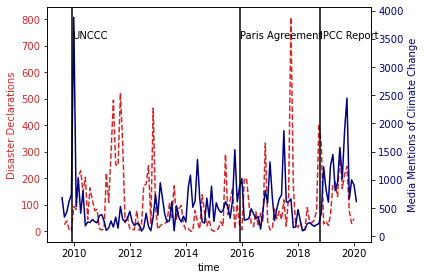

In [164]:
tot_day=cnn_day+fox_day+msnbc_day
tot_month=cnn_month+fox_month+msnbc_month
#dist2=dist2.groupby([dist2.DateTime.dt.to_period("M"),dist2.incident_type]).count()

fig, ax1=plt.subplots()

#fig.set_figwidth(40)
#fig.set_figheight(10)

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('Disaster Declarations', color=color)
ax1.plot(dist2_m['state'], "--",color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'navy'
ax2.set_ylabel('Media Mentions of Climate Change', color=color)  # we already handled the x-label with ax1
ax2.plot(tot_month, color=color, label='Total Media Mentions')

#ax2.plot(cnn_month, color=color, label='CNN')
#ax2.plot(fox_month, color="royalblue", label='Fox News')
#ax2.plot(msnbc_month, color="cornflowerblue", label='MSNBC')

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped  

import datetime
plt.axvline(datetime.date(2009,12,7), color="black")
plt.text(datetime.date(2009,12,7), 3500, 'UNCCC')

plt.axvline(datetime.date(2015,12,12), color="black")
plt.text(datetime.date(2015,12,12), 3500, 'Paris Agreement')

plt.axvline(datetime.date(2018,10,8), color="black")
plt.text(datetime.date(2018,10,8), 3500, 'IPCC Report')



#plt.legend()
plt.show()

In [26]:
#Dynamic Time Warping
#pearson coefficient


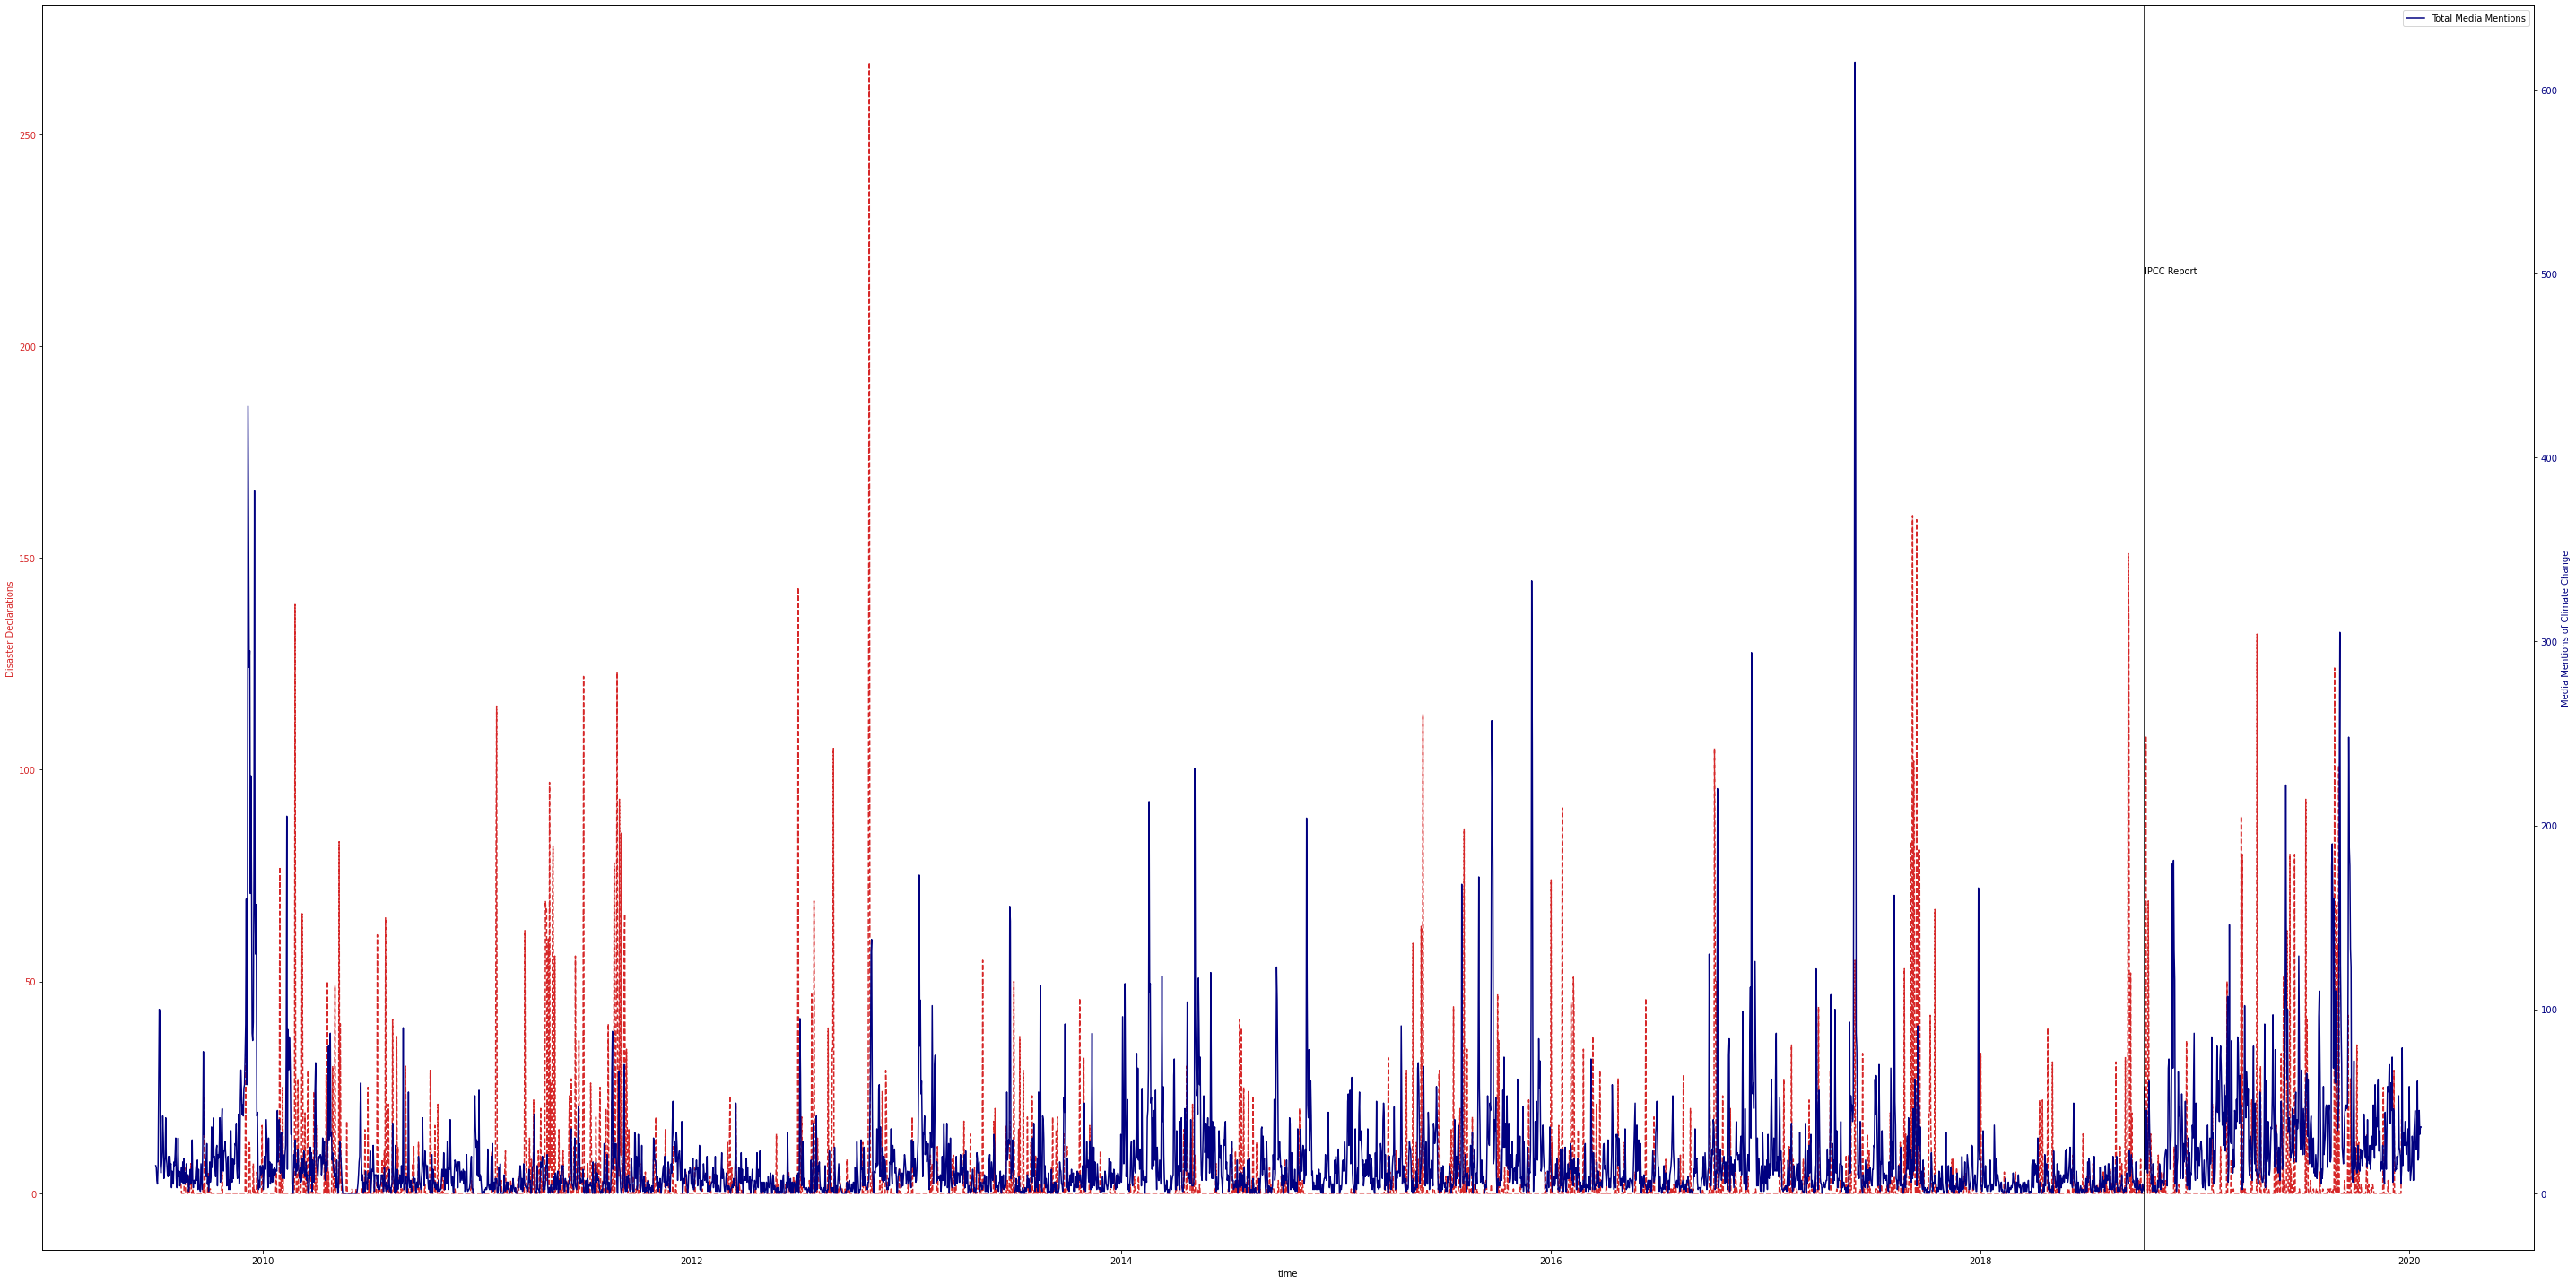

In [27]:
fig, ax1=plt.subplots()

fig.set_figwidth(40)
fig.set_figheight(20)

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('Disaster Declarations', color=color)
ax1.plot(dist2_day['state'], "--",color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'navy'
ax2.set_ylabel('Media Mentions of Climate Change', color=color)  # we already handled the x-label with ax1
ax2.plot(tot_day, color=color, label='Total Media Mentions')
#ax2.plot(cnn_day, color=color, label='CNN')
#ax2.plot(fox_day, color="royalblue", label='Fox News')
#ax2.plot(msnbc_day, color="cornflowerblue", label='MSNBC')

ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(datetime.date(2018,10,8), color="black")
plt.text(datetime.date(2018,10,8), 500, 'IPCC Report')

fig.tight_layout()  # otherwise the right y-label is slightly clipped  
plt.legend()
plt.show()

In [35]:
# plt.text(datetime.date(2016,1,1), 0, 'My date')

In [33]:
dist2.declaration_date.str.split("T", expand=True)[0]

DateTime
2009-08-13    2009-08-13
2009-08-13    2009-08-13
2009-08-14    2009-08-14
2009-08-14    2009-08-14
2009-08-15    2009-08-15
                 ...    
2019-12-19    2019-12-19
2019-12-19    2019-12-19
2019-12-19    2019-12-19
2019-12-19    2019-12-19
2019-12-19    2019-12-19
Name: 0, Length: 12741, dtype: object

In [39]:
# pd.to_datetime(dist2.DateTime)
# dt.to_period("M")